# Time To Event

In [1]:
# basic defaults, including study dates, common SQL exclusions and parquet files for anonymized data
%run -i 'data-defaults.py'

## Time to event for W pages with external links

In [3]:
w_event_time_query = """
SELECT action, 
    CAST(AVG(event_offset_time) AS DECIMAL(10,2)) AS average_time_to_event_in_ms, 
    PERCENTILE(event_offset_time,0.5) AS median_time_to_event_in_ms,
    STDDEV(event_offset_time) as stddev,
    (PERCENTILE(event_offset_time,0.75) - PERCENTILE(event_offset_time,0.25)) as iqr

FROM 
    citationusage 
WHERE wiki = 'enwiki'
    AND page_id IN 
        (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
    {}
    AND to_date(event_time) >= '{}'
    AND to_date(event_time) <= '{}'
    AND useragent_is_bot = FALSE
GROUP BY action
"""

spark.sql(
    w_event_time_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).show()

## Time to event for WP:M pages with external links

In [4]:
wpm_event_time_query = """
SELECT action, 
    CAST(AVG(event_offset_time) AS DECIMAL(10,2)) AS average_time_to_event_in_ms, 
    PERCENTILE(event_offset_time,0.5) AS median_time_to_event_in_ms,
    STDDEV(event_offset_time) as stddev,
    (PERCENTILE(event_offset_time,0.75) - PERCENTILE(event_offset_time,0.25)) as iqr

FROM 
    citationusage 
WHERE wiki = 'enwiki'
    AND page_id IN 
        (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
    {}
    AND to_date(event_time) >= '{}'
    AND to_date(event_time) <= '{}'
    AND useragent_is_bot = FALSE
GROUP BY action
"""

spark.sql(
    wpm_event_time_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).show()

## Statistics

Time to click:

In [2]:
w_click_time_offset_query = """
SELECT action, event_offset_time
FROM 
    citationusage 
WHERE wiki = 'enwiki'
AND page_id IN 
    (SELECT page_id FROM ryanmax.population_w_pages_with_extlinks)
{}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
AND action = 'extClick'
"""

w_click_time_offset = spark.sql(
    w_click_time_offset_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).sample(0.2).toPandas()

w_click_time_offset.head()

,action,event_offset_time
0,extClick,256555
1,extClick,3158
2,extClick,2830
3,extClick,41613
4,extClick,51797


In [3]:
wpm_click_time_offset_query = """
SELECT action, event_offset_time
FROM 
    citationusage 
WHERE wiki = 'enwiki'
AND page_id IN 
        (SELECT page_id FROM ryanmax.population_wpm_pages_with_extlinks)
    {}
AND to_date(event_time) >= '{}'
AND to_date(event_time) <= '{}'
AND useragent_is_bot = FALSE
AND action = 'extClick'
"""

wpm_click_time_offset = spark.sql(
    wpm_click_time_offset_query.format(
        event_exclusion_sql, start_date_string, end_date_string
    )).toPandas()

wpm_click_time_offset.head()

,action,event_offset_time
0,extClick,4192783
1,extClick,172940
2,extClick,27298
3,extClick,25466
4,extClick,21528


In [24]:
# fix data collection errors
error_rate = len(all_event_time[all_event_time.event_offset_time<=0])/len(all_event_time)
print("Proportion of samples with negative time = {}".format(error_rate))

Proportion of samples with negative time = 0.00025889116432342046


In [25]:
w_click_time_offset = w_click_time_offset[w_click_time_offset.event_offset_time > 0]
wpm_click_time_offset = wpm_click_time_offset[wpm_click_time_offset.event_offset_time > 0]

In [32]:
w_click_time_offset['group'] = "W"
wpm_click_time_offset['group'] = "WM"
w_click_time_offset['event_offset_time_seconds'] = w_click_time_offset["event_offset_time"]/1000
wpm_click_time_offset['event_offset_time_seconds'] = wpm_click_time_offset["event_offset_time"]/1000

all_event_time = w_click_time_offset.append(wpm_click_time_offset)

In [12]:
# Plots inline
%matplotlib inline

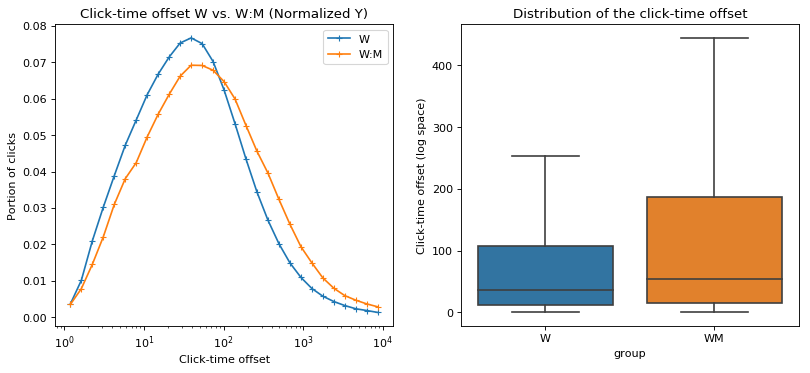

In [58]:
from scipy.stats import binned_statistic


def get_normalized_hist(bins, data):
    total_elements = len(data)
    groups = binned_statistic(data, data, bins = bins, statistic = lambda r: len(r) / total_elements)
    bin_centers = pd.Series(groups.bin_edges).rolling(2, 2).mean().dropna()
    return bin_centers, groups.statistic

bins = np.logspace(0, 4, 30, base=10)

w_distribution = get_normalized_hist(bins, w_click_time_offset.event_offset_time_seconds)
wm_distribution = get_normalized_hist(bins, wpm_click_time_offset.event_offset_time_seconds)

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)


ax = plt.plot(w_distribution[0], w_distribution[1], marker='+', label="W")
ax = plt.plot(wm_distribution[0], wm_distribution[1], marker='+', label="W:M")

plt.gca().legend(loc="upper right")
plt.gca().set_xscale("log", nonposx='clip')


plt.title("Click-time offset W vs. W:M (Normalized Y)")
plt.xlabel("Click-time offset")
plt.ylabel("Portion of clicks")

plt.subplot(122)

sns.boxplot(x="group", y="event_offset_time_seconds", data=all_event_time, showfliers=False)
plt.ylabel("Click-time offset (log space)")
plt.title("Distribution of the click-time offset")


In [59]:
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(w_click_time_offset.event_offset_time_seconds, wpm_click_time_offset.event_offset_time_seconds)
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=1777735855015.500, p < 0.001
Different distribution (reject H0)
